In [1]:
!pip install yfinance deap --quiet

In [2]:
import os
import math
import random
from datetime import datetime

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from deap import base, creator, tools

In [3]:
def make_run_dir(base_dir="runs"):
    ts = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    run_dir = os.path.join(base_dir, ts)
    os.makedirs(run_dir, exist_ok=True)
    return run_dir

run_dir = make_run_dir(base_dir="runs")
print("Saving CSVs to:", run_dir)

Saving CSVs to: runs/2026-01-13-13-24-45


In [4]:
random.seed(1)
np.random.seed(1)

In [5]:
START_DATE = "2013-01-01"
END_DATE = "2019-12-30"

N_GENERATIONS = 20
POP_SIZE = 100
TOURN_SIZE = 3
MAX_HOLDINGS = 20

In [6]:
tickers = [
    "AAPL", "AIG", "AMD", "AMZN",
    "AVGO", "BAC", "BB", "C", "CMCSA",
    "CMG", "CSCO", "CSX", "EBAY",
    "F", "FCX", "GILD", "GLW", "GOOG",
    "GOOGL", "HPQ", "INFY", "INTC",
    "JPM", "KO", "LRCX", "META", "MNST",
    "MS", "MSFT", "MU", "NFLX", "NOK",
    "ORCL", "PFE", "QQQ",
    "RF", "SBUX", "SPY", "T", "TSLA",
    "VALE", "WFC", "WMT", "XOM",
    "NVDA", 
]

# List of tickers obtained from stocks with highest volume in 2012
# From kagglehub - "jakewright/9000-tickers-of-stock-market-data-full-history"

In [7]:
def compute_obv(close: pd.Series, volume: pd.Series) -> pd.Series:
    return (np.sign(close.diff()).fillna(0) * volume).cumsum()

def compute_alpha(stock_returns: pd.Series, market_returns: pd.Series, window=60) -> pd.Series:
    """
    CAPM alpha estimate via rolling regression:
    r_i = alpha + beta * r_m + eps
    We'll do a simple rolling covariance/variance approximation.
    """
    cov = stock_returns.rolling(window).cov(market_returns)
    var = market_returns.rolling(window).var()
    beta = cov / (var + 1e-12)
    alpha = stock_returns.rolling(window).mean() - beta * market_returns.rolling(window).mean()
    return alpha

def compute_linguistic_vars(df_stock: pd.DataFrame, market_close: pd.Series) -> pd.DataFrame:
    """
    Returns a DataFrame with the 9 variables (per day).
    Portfolio Value is NOT here yet (it is injected at rebalance time as a scalar).
    """
    close = df_stock["Close"].astype(float)
    volume = df_stock["Volume"].astype(float)

    # 1) Price Change (20d)
    price_change = close.pct_change(20)

    # 2-3) SMA Buy/Sell signal (difference vs 20d SMA, split by sign)
    sma20 = close.rolling(20).mean()
    sma_diff = close - sma20
    sma_buy = sma_diff.where(sma_diff > 0, 0.0)
    sma_sell = (-sma_diff).where(sma_diff < 0, 0.0)  # positive when below SMA

    # 5-6) DMA Buy/Sell (10d vs 20d MA, split by sign)
    ma10 = close.rolling(10).mean()
    dma_diff = ma10 - sma20
    dma_buy = dma_diff.where(dma_diff > 0, 0.0)
    dma_sell = (-dma_diff).where(dma_diff < 0, 0.0)

    # 7-8) OBV Buy/Sell signals (divergence to max/min over last 20d)
    obv = compute_obv(close, volume)
    obv_buy = (close.rolling(20).max() - close) + (obv.rolling(20).max() - obv)
    obv_sell = (close - close.rolling(20).min()) + (obv - obv.rolling(20).min())

    # 9) Alpha (rolling 60d returns vs market returns)
    stock_ret = close.pct_change()
    market_ret = market_close.pct_change()
    alpha = compute_alpha(stock_ret, market_ret, window=60)

    out = pd.DataFrame({
        "PriceChange": price_change,
        "SMABuy": sma_buy,
        "SMASell": sma_sell,
        # "PortfolioValue" will be injected later at rebalance time
        "DMABuy": dma_buy,
        "DMASell": dma_sell,
        "OBVBuy": obv_buy,
        "OBVSell": obv_sell,
        "Alpha": alpha
    }, index=df_stock.index)

    return out


- **EL** – Extremely Low  
- **VL** – Very Low  
- **L** – Low  
- **M** – Medium  
- **H** – High  
- **VH** – Very High  
- **EH** – Extremely High  

In [8]:
FUZZY_SETS = ["EL","VL","L","M","H","VH","EH"]  # 7 sets

def build_membership_params(series: pd.Series) -> list[tuple[float,float,float]]:
    """
    Build 7 triangular membership functions from historical observations:
    each fuzzy set gets a (min, center, max) from equal-frequency bins.
    Returns list of 7 tuples (min, center, max).
    """
    s = series.dropna().astype(float).values
    if len(s) < 50:
        # fallback if too few points
        mn, mx = float(np.nanmin(s)) if len(s) else 0.0, float(np.nanmax(s)) if len(s) else 1.0
        centers = np.linspace(mn, mx, 7)
        return [(mn, float(c), mx) for c in centers]

    s.sort()
    bins = np.array_split(s, 7)
    params = []
    for b in bins:
        bmin = float(b[0])
        bmax = float(b[-1])
        bctr = float(np.mean(b))
        # avoid degenerate triangles
        if bmin == bmax:
            bmax = bmin + 1e-9
        params.append((bmin, bctr, bmax))
    return params

def tri_membership(x: float, mn: float, ctr: float, mx: float) -> float:
    if not np.isfinite(x):
        return 0.0
    if x < mn or x > mx:
        return 0.0
    if x == ctr:
        return 1.0
    if x < ctr:
        return (x - mn) / (ctr - mn + 1e-12)
    return (x - mx) / (ctr - mx + 1e-12)  # descending

def fuzzify_7(x: float, params_7: list[tuple[float,float,float]]) -> np.ndarray:
    return np.array([tri_membership(x, *p) for p in params_7], dtype=float)


In [9]:
VAR_NAMES = [
    "PriceChange", "SMABuy", "SMASell",
    "PortfolioValue",
    "DMABuy", "DMASell",
    "OBVBuy", "OBVSell",
    "Alpha"
]
V = len(VAR_NAMES)

In [10]:
def rule_len(V: int) -> int:
    return 2*V + 2

def rating_from_idx(ridx: int) -> float:
    ridx = int(np.clip(ridx, 0, 9))
    return (ridx + 1) / 10.0  # 0.1..1.0

In [11]:
def decode_rulebase(individual, O: int, V: int):
    L = rule_len(V)
    rules = []
    for k in range(O):
        chunk = individual[k*L:(k+1)*L]
        active = bool(chunk[0])
        var_active = []
        var_fset = []
        pos = 1
        for j in range(V):
            var_active.append(bool(chunk[pos])); pos += 1
            var_fset.append(int(chunk[pos])); pos += 1
        rating_idx = int(chunk[pos])
        rules.append((active, var_active, var_fset, rating_idx))
    return rules


In [12]:
def stock_rating(rulebase_rules, x_vars: dict, membership_params: dict) -> float:
    """
    x_vars: dict var_name -> float value (includes PortfolioValue)
    membership_params: dict var_name -> list of 7 (min,center,max)
    """
    num = 0.0
    den = 0.0

    for (r_active, var_active, var_fset, rating_idx) in rulebase_rules:
        if not r_active:
            continue

        rating = rating_from_idx(rating_idx)
        # compute rule match = product of memberships of active vars
        match = 1.0
        any_cond = False

        for j, vname in enumerate(VAR_NAMES):
            if not var_active[j]:
                continue
            any_cond = True
            fset_idx = int(np.clip(var_fset[j], 0, 6))
            params_7 = membership_params[vname]
            mu = fuzzify_7(float(x_vars[vname]), params_7)[fset_idx]
            match *= mu

        if not any_cond:
            # rule with no conditions is useless; skip
            continue

        out_i = match * rating
        num += out_i
        den += match

    if den <= 1e-12:
        return 0.0
    return num / den


In [13]:
def simulate_portfolio(rulebase_rules,
    features_by_ticker: dict,
    prices_by_ticker: dict,
    membership_params: dict,
    dates: pd.DatetimeIndex,
    d: int = 20,
    buy_pct: float = 0.10,
    sell_pct: float = 0.05,
    max_holdings: int = 100,
    tx_cost: float = 0.001,
    initial_capital: float = 1_000_000.0,
    record_trades: bool = False,
    window_tag: str = "" 
):
    """
    Returns:
      equity_curve (pd.Series), penalties_loss (float)
    """
    cash = float(initial_capital)
    holdings = {}  # ticker -> shares
    equity = []
    penalty = 0.0

    trades = []

    def portfolio_value(t):
        val = cash
        for tk, sh in holdings.items():
            val += sh * float(prices_by_ticker[tk].loc[t])
        return val

    prev_rebalance_val = None

    for idx, t in enumerate(dates):
        # Mark-to-market daily
        equity.append(portfolio_value(t))

        # Rebalance every d days (skip day 0)
        if idx % d != 0:
            continue

        pv = portfolio_value(t)
        # downside penalty on rebalance days (paper Section III-D, Eq.6 style)
        if prev_rebalance_val is not None:
            delta = (pv - prev_rebalance_val) / (prev_rebalance_val + 1e-12)
            if delta <= -0.10:
                penalty += 10.0
            elif delta <= -0.05:
                penalty += 0.1
            # else: no penalty
        prev_rebalance_val = pv

        # Build ratings for all stocks using PortfolioValue as an input variable
        ratings = []
        pv_norm = pv / initial_capital  # simple normalization

        for tk in features_by_ticker.keys():
            feat_row = features_by_ticker[tk].loc[t]
            x_vars = {vn: float(feat_row[vn]) for vn in feat_row.index}
            x_vars["PortfolioValue"] = float(pv_norm)
            r = stock_rating(rulebase_rules, x_vars, membership_params)
            ratings.append((tk, r))

        ratings.sort(key=lambda x: x[1], reverse=True)
        n = len(ratings)
        if n == 0:
            continue

        buy_n = max(1, int(math.ceil(buy_pct * n)))
        sell_n = max(1, int(math.ceil(sell_pct * n)))

        top_set = set([tk for tk, _ in ratings[:buy_n]])
        bottom_set = set([tk for tk, _ in ratings[-sell_n:]])

        # --- SELL: holdings that are in the bottom set ---
        to_sell = [tk for tk in list(holdings.keys()) if tk in bottom_set]
        for tk in to_sell:
            px = float(prices_by_ticker[tk].loc[t])
            sh = holdings.pop(tk)
            proceeds = sh * px
            cash += proceeds * (1.0 - tx_cost)

            if record_trades:
                trades.append({
                    "Date": t,
                    "Ticker": tk,
                    "Action": "SELL",
                    "Shares": sh,
                    "Price": px,
                    "Proceeds": proceeds,
                    "Window": window_tag,
                    "portfolio_value_after": portfolio_value(t)
                })

        # --- BUY: pick from top set if not already held ---
        # Target holdings = current holdings ∪ top_set, capped by max_holdings
        current = set(holdings.keys())
        target = list(current.union(top_set))
        # Keep only highest-rated if too many
        if len(target) > max_holdings:
            rank_map = {tk: r for tk, r in ratings}
            target.sort(key=lambda tk: rank_map.get(tk, -1e9), reverse=True)
            target = target[:max_holdings]


        # Determine which to buy (in target but not held)
        need_buy = [tk for tk in target if tk not in holdings]

        # if idx % d == 0 and idx != 0:
        #     print(t.date(), "PV", pv, "cash", cash, "holdings", len(holdings),
        #         "need_buy", len(need_buy))

        if len(need_buy) > 0 and cash > 0:
            # Equal-weight allocate available cash across new buys
            alloc_per = cash / len(need_buy)
            for tk in need_buy:
                px = float(prices_by_ticker[tk].loc[t])
                if px <= 0:
                    continue
                spend = alloc_per * (1.0 - tx_cost)
                sh = spend / px
                if sh > 0:
                    holdings[tk] = holdings.get(tk, 0.0) + sh
                    cash -= alloc_per  # spend allocated chunk (including cost)

                    if record_trades:
                        trades.append({
                            "Date": t,
                            "Ticker": tk,
                            "Action": "BUY",
                            "Shares": sh,
                            "Price": px,
                            "Proceeds": spend,
                            "Window": window_tag,
                            "portfolio_value_after": portfolio_value(t)
                        })

    equity_series = pd.Series(equity, index=dates)
    trades_df = pd.DataFrame(trades)
    return equity_series, penalty , trades_df


In [14]:
def count_active_rules(rulebase_rules) -> int:
    return sum(1 for r in rulebase_rules if r[0])

def fitness_rulebase(individual,
                     O: int,
                     features_by_ticker: dict,
                     prices_by_ticker: dict,
                     membership_params: dict,
                     dates: pd.DatetimeIndex,
                     ockham_k: float = 0.01):
    rulebase_rules = decode_rulebase(individual, O, V)

    equity, loss_pen, _trades_df = simulate_portfolio(
        rulebase_rules=rulebase_rules,
        features_by_ticker=features_by_ticker,
        prices_by_ticker=prices_by_ticker,
        membership_params=membership_params,
        dates=dates,
        d=20,
        buy_pct=0.10,
        sell_pct=0.05,
        max_holdings=100,
        tx_cost=0.001,
        initial_capital=1_000_000.0,
        record_trades=False
    )

    # ROI as V_end / V_start (simple, consistent with paper’s ROI intent)
    roi = float(equity.iloc[-1] / (equity.iloc[0] + 1e-12))

    # Ockham penalty (paper Eq.7)
    ockham_pen = ockham_k * count_active_rules(rulebase_rules)

    # Fitness = ROI - penalties
    fit = roi - (loss_pen + ockham_pen)
    if not np.isfinite(fit):
        fit = -1e9
    return (fit,)


In [15]:
def prepare_market_data(tickers, market_ticker="SPY", start="2015-01-01", end="2025-01-01"):
    all_tk = list(set(tickers + [market_ticker]))
    data = yf.download(all_tk, start=start, end=end, auto_adjust=True, progress=False)

    prices_by_ticker = {}
    features_by_ticker = {}

    market_close = data["Close"][market_ticker].dropna()

    for tk in tickers:
        df = pd.DataFrame({
            "Close": data["Close"][tk],
            "Volume": data["Volume"][tk]
        }).dropna()

        # align to market dates intersection
        df = df.loc[df.index.intersection(market_close.index)]

        feats8 = compute_linguistic_vars(df, market_close.loc[df.index])  # 8 vars
        # add placeholder column for PortfolioValue so indexing is consistent
        feats9 = feats8.copy()
        feats9["PortfolioValue"] = np.nan  # injected later per rebalance day

        prices_by_ticker[tk] = df["Close"]
        features_by_ticker[tk] = feats9

    # Common dates across all tickers (important)
    common_dates = None
    for tk in tickers:
        common_dates = prices_by_ticker[tk].index if common_dates is None else common_dates.intersection(prices_by_ticker[tk].index)
    common_dates = common_dates.sort_values()

    # membership params computed from training window observations (per variable)
    # We compute params from pooled observations across all stocks for each variable
    membership_params = {}
    for vname in VAR_NAMES:
        if vname == "PortfolioValue":
            # portfolio value is dynamic; define a generic range
            # You can refine this using simulated PV history, but this works.
            series = pd.Series(np.linspace(0.5, 2.0, 500))
        else:
            pooled = []
            for tk in tickers:
                pooled.append(features_by_ticker[tk][vname])
            series = pd.concat(pooled, axis=0)
        membership_params[vname] = build_membership_params(series)

    return features_by_ticker, prices_by_ticker, membership_params, common_dates


In [16]:
def make_toolbox(O: int):
    L = rule_len(V)
    IND_SIZE = O * L

    if "FitnessMax" not in creator.__dict__:
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    if "Individual" not in creator.__dict__:
        creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()

    def gene_sampler(pos_in_rule: int):
        """
        pos_in_rule: 0..(2V+1)
        Layout: [rule_active] + V*(var_active, fuzzy_idx) + [rating_idx]
        """
        if pos_in_rule == 0:
            return random.randint(0, 1)  # rule active
        # rating at last position
        if pos_in_rule == (2*V + 1):
            return random.randint(0, 9)  # rating idx
        # inside variable pairs
        # odd positions: var_active, even positions: fuzzy_idx
        if (pos_in_rule - 1) % 2 == 0:
            return random.randint(0, 1)  # var_active
        else:
            return random.randint(0, 6)  # fuzzy set index

    def individual_init():
        ind = []
        for _ in range(O):
            for p in range(2*V + 2):
                ind.append(gene_sampler(p))
        return creator.Individual(ind)

    toolbox.register("individual", individual_init)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("select", tools.selTournament, tournsize=TOURN_SIZE)
    toolbox.register("mate", tools.cxUniform, indpb=0.5)

    def mutate(ind, indpb=0.05):
        # mutate each gene with probability indpb, respecting domains
        for k in range(O):
            base_idx = k * (2*V + 2)
            for p in range(2*V + 2):
                if random.random() < indpb:
                    idx = base_idx + p
                    ind[idx] = gene_sampler(p)
        return (ind,)

    toolbox.register("mutate", mutate)
    return toolbox


In [17]:
def evolve_rulebase_for_window(
    features_by_ticker,
    prices_by_ticker,
    membership_params,
    window_dates,
    O=10,
    pop_size=60,
    ngen=40,
    cxpb=0.6,
    mutpb=0.4,
    ockham_k=0.01
):
    toolbox = make_toolbox(O)

    def eval_fn(ind):
        return fitness_rulebase(
            ind, O=O,
            features_by_ticker=features_by_ticker,
            prices_by_ticker=prices_by_ticker,
            membership_params=membership_params,
            dates=window_dates,
            ockham_k=ockham_k
        )

    toolbox.register("evaluate", eval_fn)

    pop = toolbox.population(n=pop_size)

    # ---- initial evaluation ----
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    best = tools.selBest(pop, 1)[0]
    best_fitness = best.fitness.values[0]

    print(f"Initial best fitness: {best_fitness:.6f}")

    # ---- evolution ----
    for gen in range(ngen):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # crossover
        for c1, c2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(c1, c2)
                del c1.fitness.values
                del c2.fitness.values

        # mutation
        for m in offspring:
            if random.random() < mutpb:
                toolbox.mutate(m, indpb=0.05)
                del m.fitness.values

        # re-evaluation
        invalid = [i for i in offspring if not i.fitness.valid]
        for ind in invalid:
            ind.fitness.values = toolbox.evaluate(ind)

        pop = offspring

        cand = tools.selBest(pop, 1)[0]
        cand_fitness = cand.fitness.values[0]

        # ---- print ONLY if improved ----
        if cand_fitness > best_fitness:
            best = cand
            best_fitness = cand_fitness
            print(f"Gen {gen:02d} NEW best fitness: {best_fitness:.6f}")
        
    rb_best = decode_rulebase(best, O, V)

    eq_train, pen_train, trades_train = simulate_portfolio(
        rulebase_rules=rb_best,
        features_by_ticker=features_by_ticker,
        prices_by_ticker=prices_by_ticker,
        membership_params=membership_params,
        dates=window_dates,
        d=20,
        buy_pct=0.10,
        sell_pct=0.05,
        max_holdings=100,
        tx_cost=0.001,
        initial_capital=1_000_000.0,
        record_trades=True,
        window_tag=f"TRAIN_{window_dates[0].date()}_{window_dates[-1].date()}",
    )
    if not trades_train.empty:
        trades_train.to_csv(
            os.path.join(run_dir, f"trades_train_{window_dates[0].date()}_{window_dates[-1].date()}.csv"),
            index=False
        )

    return best


### Example output of trades_train_ files

```csv
Date,Ticker,Action,Shares,Price,Proceeds,Window,portfolio_value_after
2013-11-14,TSLA,BUY,21780.523648299182,9.173333168029785,199800.0,TRAIN_2013-11-14_2014-05-08,999800.0
2013-11-14,AMD,BUY,56761.36394393099,3.5199999809265137,199800.0,TRAIN_2013-11-14_2014-05-08,999600.0
2013-11-14,AVGO,BUY,62848.59256961593,3.1790688037872314,199800.0,TRAIN_2013-11-14_2014-05-08,999400.0
2013-11-14,CSCO,BUY,13606.427521075122,14.684236526489258,199800.0,TRAIN_2013-11-14_2014-05-08,999200.0
2013-11-14,BB,BUY,30833.33324257729,6.480000019073486,199800.0,TRAIN_2013-11-14_2014-05-08,999000.0
2014-03-13,TSLA,SELL,21780.523648299182,15.852666854858398,345279.385320852,TRAIN_2013-11-14_2014-05-08,1338763.4481029473
2014-03-13,VALE,BUY,19554.570999246294,5.873974800109863,114863.05727653188,TRAIN_2013-11-14_2014-05-08,1338648.4700676354
2014-03-13,INFY,BUY,23083.17592663849,4.976050853729248,114863.05727653188,TRAIN_2013-11-14_2014-05-08,1338533.4920323235
2014-03-13,CMCSA,BUY,6339.7492573064055,18.117918014526367,114863.05727653188,TRAIN_2013-11-14_2014-05-08,1338418.5139970116
```

In [18]:
def buy_and_hold_window_return(prices_by_ticker: dict, tickers: list, trade_dates: pd.DatetimeIndex) -> float:
    """
    Computes buy&hold return over ONE trade window:
    equal weight buy on first day of trade_dates, sell on last day.
    """
    # Build a close price matrix for this window
    prices_close = pd.DataFrame({tk: prices_by_ticker[tk].loc[trade_dates] for tk in tickers})
    prices_close = prices_close.ffill().dropna(axis=1, how="any")  # require full window

    if prices_close.shape[1] == 0:
        return 0.0

    start_px = prices_close.iloc[0]
    end_px = prices_close.iloc[-1]

    # Equal-weight portfolio return = mean of individual returns (with equal weights)
    indiv_rets = (end_px / start_px) - 1.0
    return float(indiv_rets.mean())

In [19]:
def run_ea_strategy_sliding_windows(
    tickers,
    start="2015-01-01",
    end="2025-01-01",
    window_len=120,
    step=20,
    O=10,
    initial_capital=1_000_000.0,
    ea_buy_pct=0.40,
    ea_sell_pct=0.20,
    ea_max_holdings=5,
    ea_rebalance_d=20,
    tx_cost=0.001,
):
    """
    Runs ONLY the EA strategy in a rolling train / forward-trade scheme.
    Returns:
      best_per_window, window_report_df, ea_comp_curve
    """
    features_by_ticker, prices_by_ticker, membership_params, dates = prepare_market_data(
        tickers=tickers, market_ticker="SPY", start=start, end=end
    )

    dates = dates[200:]  # warmup

    best_per_window = []
    window_rows = []

    ea_equity = float(initial_capital)
    ea_equity_points = []
    equity_dates = []

    all_trades = []

    for w_start in range(0, len(dates) - window_len - step, step):
        train_dates = dates[w_start:w_start + window_len]
        trade_dates = dates[w_start + window_len:w_start + window_len + step]
        if len(trade_dates) == 0:
            continue

        print(f"\nWindow train: {train_dates[0].date()} -> {train_dates[-1].date()}")

        best = evolve_rulebase_for_window(
            features_by_ticker, prices_by_ticker, membership_params,
            window_dates=train_dates,
            O=O, pop_size=POP_SIZE, ngen=N_GENERATIONS
        )
        best_per_window.append(best)

        rb = decode_rulebase(best, O, V)

        # Evaluate EA on THIS trade window (fresh initial capital for window return)
        equity_seg, pen, trades_seg = simulate_portfolio(
            rulebase_rules=rb,
            features_by_ticker=features_by_ticker,
            prices_by_ticker=prices_by_ticker,
            membership_params=membership_params,
            dates=trade_dates,
            d=ea_rebalance_d,
            buy_pct=ea_buy_pct,
            sell_pct=ea_sell_pct,
            max_holdings=ea_max_holdings,
            tx_cost=tx_cost,
            initial_capital=initial_capital,
            record_trades=True,
            window_tag=f"TRADE_{trade_dates[0].date()}_{trade_dates[-1].date()}",
        )

        if not trades_seg.empty:
            all_trades.append(trades_seg)

        ea_win_ret = float(equity_seg.iloc[-1] / equity_seg.iloc[0] - 1.0)

        # compound into a single curve
        ea_equity *= (1.0 + ea_win_ret)
        equity_dates.append(trade_dates[-1])
        ea_equity_points.append(ea_equity)

        window_rows.append({
            "train_start": train_dates[0],
            "train_end": train_dates[-1],
            "trade_start": trade_dates[0],
            "trade_end": trade_dates[-1],
            "ea_win_return": ea_win_ret,
            "ea_comp_equity": ea_equity,
            "penalty": float(pen),
        })

        print(f"Window report: {window_rows[-1]}")

    window_report = pd.DataFrame(window_rows)
    ea_comp_curve = pd.Series(ea_equity_points, index=pd.DatetimeIndex(equity_dates), name="EACompEquity")

    all_trades_df = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame()

    return best_per_window, window_report, ea_comp_curve, prices_by_ticker, all_trades_df

In [20]:
def run_buy_and_hold_baseline(
    prices_by_ticker: dict,
    tickers: list,
    start_date,
    end_date,
    initial_capital=1_000_000.0
) -> pd.Series:
    """
    One-shot baseline:
    equal-weight buy on start_date, hold, sell on end_date.
    Returns DAILY equity curve over [start_date, end_date].
    """
    # Build price matrix and align
    prices_close = pd.DataFrame({tk: prices_by_ticker[tk].loc[start_date:end_date] for tk in tickers})
    prices_close = prices_close.sort_index().ffill().dropna(axis=1, how="any")

    if prices_close.shape[1] == 0:
        return pd.Series(dtype=float, name="BuyHold")

    start_px = prices_close.iloc[0]
    weights = pd.Series(1.0 / len(start_px), index=start_px.index)

    shares = (initial_capital * weights) / start_px
    equity = (prices_close * shares).sum(axis=1)
    equity.name = "BuyHold"
    return equity

In [21]:
def run_buy_and_hold_sliding_windows(
    prices_by_ticker: dict,
    tickers: list,
    dates: pd.DatetimeIndex,
    window_len=120,
    step=20,
    initial_capital=1_000_000.0
):
    """
    Window-by-window buy&hold baseline that matches EA compounding logic:
    for each trade window, buy equal-weight at start, sell at end, compound returns.
    Returns:
      bh_window_report_df, bh_comp_curve
    """
    bh_equity = float(initial_capital)
    bh_equity_points = []
    equity_dates = []
    rows = []

    for w_start in range(0, len(dates) - window_len - step, step):
        trade_dates = dates[w_start + window_len:w_start + window_len + step]
        if len(trade_dates) == 0:
            continue

        bh_win_ret = buy_and_hold_window_return(prices_by_ticker, tickers, trade_dates)

        bh_equity *= (1.0 + bh_win_ret)
        equity_dates.append(trade_dates[-1])
        bh_equity_points.append(bh_equity)

        rows.append({
            "trade_start": trade_dates[0],
            "trade_end": trade_dates[-1],
            "bh_win_return": bh_win_ret,
            "bh_comp_equity": bh_equity,
        })

    bh_report = pd.DataFrame(rows)
    bh_comp_curve = pd.Series(bh_equity_points, index=pd.DatetimeIndex(equity_dates), name="BHCompEquity")
    return bh_report, bh_comp_curve


Window train: 2013-10-17 -> 2014-04-09
Initial best fitness: 1.172044
Gen 00 NEW best fitness: 1.182044
Gen 05 NEW best fitness: 1.202044
Gen 07 NEW best fitness: 1.247820
Gen 14 NEW best fitness: 1.267820
Window report: {'train_start': Timestamp('2013-10-17 00:00:00'), 'train_end': Timestamp('2014-04-09 00:00:00'), 'trade_start': Timestamp('2014-04-10 00:00:00'), 'trade_end': Timestamp('2014-05-08 00:00:00'), 'ea_win_return': 0.016616423342207032, 'ea_comp_equity': 1016616.423342207, 'penalty': 0.0}

Window train: 2013-11-14 -> 2014-05-08
Initial best fitness: 1.176984
Gen 04 NEW best fitness: 1.186984
Gen 05 NEW best fitness: 1.280908
Gen 11 NEW best fitness: 1.292777
Window report: {'train_start': Timestamp('2013-11-14 00:00:00'), 'train_end': Timestamp('2014-05-08 00:00:00'), 'trade_start': Timestamp('2014-05-09 00:00:00'), 'trade_end': Timestamp('2014-06-06 00:00:00'), 'ea_win_return': 0.06424521737037714, 'ea_comp_equity': 1081929.1664421223, 'penalty': 0.0}

Window train: 2013-

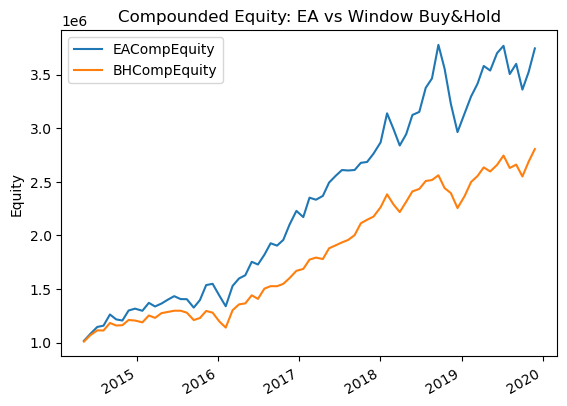

   trade_start  trade_end  ea_win_return  bh_win_return  ea_comp_equity  \
0   2014-04-10 2014-05-08       0.016616       0.009724    1.016616e+06   
1   2014-05-09 2014-06-06       0.064245       0.059367    1.081929e+06   
2   2014-06-09 2014-07-07       0.059446       0.041658    1.146245e+06   
3   2014-07-08 2014-08-04       0.010206      -0.001107    1.157944e+06   
4   2014-08-05 2014-09-02       0.090331       0.063085    1.262542e+06   
..         ...        ...            ...            ...             ...   
66  2019-07-10 2019-08-06      -0.069905      -0.042188    3.505687e+06   
67  2019-08-07 2019-09-04       0.027098       0.011858    3.600685e+06   
68  2019-09-05 2019-10-02      -0.066711      -0.041607    3.360478e+06   
69  2019-10-03 2019-10-30       0.048840       0.054113    3.524604e+06   
70  2019-10-31 2019-11-27       0.062512       0.043794    3.744933e+06   

    bh_comp_equity  penalty  
0     1.009724e+06      0.0  
1     1.069668e+06      0.0  
2     1.1

In [ ]:
best_models, ea_report, ea_comp, prices_by_ticker, all_trades_df = run_ea_strategy_sliding_windows(
    tickers=tickers,
    start=START_DATE,
    end=END_DATE,
    window_len=120,
    step=20,
    O=10,
    initial_capital=1_000_000.0,
    ea_max_holdings=MAX_HOLDINGS,
    ea_buy_pct=0.2,
    ea_sell_pct=0.15
)

# Make buy&hold use the SAME dates/warmup slicing logic:
# easiest: reconstruct dates the same way as EA did
features_by_ticker, _, _, dates = prepare_market_data(tickers, "SPY", START_DATE, END_DATE)
dates = dates[200:]

bh_report, bh_comp = run_buy_and_hold_sliding_windows(
    prices_by_ticker=prices_by_ticker,
    tickers=tickers,
    dates=dates,
    window_len=120,
    step=20,
    initial_capital=1_000_000.0
)

# Combine for plotting/reporting
comp_df = pd.concat([ea_comp, bh_comp], axis=1)
ax = comp_df.plot()
ax.set_title("Compounded Equity: EA vs Window Buy&Hold")
ax.set_ylabel("Equity")
plt.show()

# Merge per-window reports if you want one table
report = ea_report.merge(bh_report, on=["trade_start","trade_end"], how="left")
print(report[["trade_start","trade_end","ea_win_return","bh_win_return","ea_comp_equity","bh_comp_equity","penalty"]])
print("\nFinal:")
print("EA:", float(ea_comp.iloc[-1]))
print("Buy&Hold:", float(bh_comp.iloc[-1]))

In [23]:
all_trades_df.to_csv(os.path.join(run_dir, "trades_all_trade_windows.csv"), index=False)
report.to_csv(os.path.join(run_dir, "window_report.csv"), index=False)
ea_comp.to_csv(os.path.join(run_dir, "ea_comp_curve.csv"))
bh_comp.to_csv(os.path.join(run_dir, "bh_comp_curve.csv"))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot equity curves
comp_df.plot(ax=ax, linewidth=2)

ax.set_title("Compounded Equity: EA vs Buy & Hold, Initial capital: $1,000,000", fontsize=13)
ax.set_xlabel("Date")
ax.set_ylabel("Portfolio Value")

ea_final = ea_comp.iloc[-1]
bh_final = bh_comp.iloc[-1]
end_date = comp_df.index[-1]

fmt = lambda x: f"${x/1e6:.2f}M"

ax.scatter([end_date], [ea_final], zorder=5)
ax.scatter([end_date], [bh_final], zorder=5)

ax.annotate(
    f"EA final: {fmt(ea_final)}",
    xy=(end_date, ea_final),
    xytext=(-90, 12),
    textcoords="offset points",
    ha="right",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9)
)

ax.annotate(
    f"Buy & Hold final: {fmt(bh_final)}",
    xy=(end_date, bh_final),
    xytext=(-90, -18),
    textcoords="offset points",
    ha="right",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9)
)

ax.grid(alpha=0.3)
plt.tight_layout()

plt.savefig("compounded_equity_ea_vs_bh.png", dpi=150)
plt.close(fig)